In [1]:
import numpy as np
import pandas as pd 
import scipy as sp
import scipy.io
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.signal import find_peaks
from datetime import datetime


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



import os
import glob
import fnmatch
import re


## Read Arapuca run log 

In [2]:
df_Xerunlist = pd.read_csv('./XeArapucaRunList.csv', sep = ';')
df_Xerunlist.head()

,Run Number,Config,Day/time,Comments,Efield
0,10872,CRT_noprescale_delay_Feb00003,06/02/2020,First run after solving the noise problem. All...,False
1,10873,CRT_noprescale_delay_Feb00003,06/02/2020,Started using CRT trigger. Biases for channels...,False
2,10874,CRT_noprescale_delay_Feb00003,06/02/2020,"Biases for channels 0,6 and 8 to 11 of SSP 504...",False
3,10875,CRT_noprescale_delay_Feb00003,06/02/2020,Biases for channels 0 to 7 of SSP 504 brought ...,False
4,10877,XeDope_CRT_noprescale_delay_Feb00002,06/02/2020,New config with lower disc thresholds (70 ADC ...,False


In [3]:
df_Xerunlist.shape

(121, 5)

In [4]:
## add tiem infos
df_Xetimelist = pd.read_csv('./timeinfos.txt', sep = '\t', header=None, names={'Run Number', 'daytime'})

df_Xetimelist['daytime'] = pd.to_datetime(df_Xetimelist['daytime'])
df_Xetimelist.tail()

,Run Number,daytime
113,11262,2020-05-17 09:19:41+00:00
114,11264,2020-05-18 01:56:25+00:00
115,11265,2020-05-18 12:56:43+00:00
116,11269,2020-05-18 21:59:25+00:00
117,11270,2020-05-19 08:14:45+00:00


In [5]:
df_Xetimelist.shape

(118, 2)

In [6]:
df_Xetimelist = df_Xetimelist.sort_values(by=['Run Number'] ).drop_duplicates(ignore_index = True)
df_Xetimelist.shape

(106, 2)

In [7]:
df_tmp = pd.merge(df_Xerunlist, df_Xetimelist, how = 'inner', on=['Run Number'])
df_tmp.head(2)

,Run Number,Config,Day/time,Comments,Efield,daytime
0,10872,CRT_noprescale_delay_Feb00003,06/02/2020,First run after solving the noise problem. All...,False,2020-02-06 13:51:48+00:00
1,10873,CRT_noprescale_delay_Feb00003,06/02/2020,Started using CRT trigger. Biases for channels...,False,2020-02-06 14:03:28+00:00


In [8]:
df_Xerunlist_info = df_tmp[['Run Number', 'Day/time', 'daytime', 'Efield']]
df_Xerunlist_info['Day/time'] = pd.to_datetime(df_Xerunlist_info['Day/time'], format='%d/%m/%Y')
#df_Xerunlist_info['Day/time'] = df_Xerunlist_info['Day/time'].dt.strftime('%d %b')
df_Xerunlist_info.tail()

,Run Number,Day/time,daytime,Efield
90,11264,2020-05-18,2020-05-18 01:56:25+00:00,False
91,11265,2020-05-18,2020-05-18 12:56:43+00:00,False
92,11269,2020-05-19,2020-05-18 21:59:25+00:00,False
93,11270,2020-05-19,2020-05-19 08:14:45+00:00,False
94,11271,2020-05-20,2020-05-19 20:28:58+00:00,False


In [9]:
df_Xerunlist_info.shape

(95, 4)

## Read my files and do the analysis

In [10]:
# read APA 6 files 

base_path_mod603 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod603/Integral/'
file_path_mod603 = os.path.join(base_path_mod603,'CalibratedIntegral_*.csv')

file_name_list_mod603 =  glob.glob(file_path_mod603) 
print(' Getting infos from ', len(file_name_list_mod603), 'runs ')

Getting infos from  76 runs 


In [11]:
# read APA 3 files 

base_path_mod304 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod304/Integral/'
file_path_mod304 = os.path.join(base_path_mod304,'CalibratedIntegral_*.csv')

file_name_list_mod304 =  glob.glob(file_path_mod304) 
print(' Getting infos from ', len(file_name_list_mod304), 'runs ')

Getting infos from  97 runs 


In [12]:
def readfile_list(filename_list):       
    
    def read_single_file(f):
        data = pd.read_csv(f, index_col=0)
        return data
    
    data_list = [read_single_file(f) for f in filename_list]
    return pd.concat(data_list, axis=0)

In [13]:
df_603 = readfile_list(file_name_list_mod603)
df_603.head()

,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
0,11021,0,5534.322105,438.797034,144.886754,1.000000,6804
1,11021,1,14117.131841,450.359705,152.530278,1.026351,2504
2,11021,2,13022.030469,448.850498,143.627997,1.022911,2385
3,11021,3,15045.207965,415.431604,156.352321,0.946751,2247
4,11021,4,7202.065870,444.835992,145.092221,1.013763,6747


In [14]:
df_603.tail()

,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
7,11018,7,14507.357911,436.579731,152.571426,0.999839,1096
8,11018,8,9557.617879,414.980684,153.115170,0.950374,2893
9,11018,9,17493.592542,447.377209,168.259868,1.024567,1224
10,11018,10,18237.614506,439.406290,164.985369,1.006313,1267
11,11018,11,4343.921055,439.401223,130.860546,1.006301,2931


In [15]:
df_304 = readfile_list(file_name_list_mod304)
df_304.head()

,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
0,11021,0,7554.093236,475.629607,164.225912,1.000000,10620
1,11021,1,5965.158716,473.798684,163.436650,0.996151,10694
2,11021,2,6811.382174,478.290037,163.970221,1.005593,10659
3,11021,3,5707.479941,491.526595,165.134200,1.033423,10700
4,11021,4,13929.721287,477.829584,163.054736,1.004625,4830


In [16]:
df_304.tail()

,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
7,11159,7,22601.894043,422.675538,148.421184,0.885177,2514
8,11159,8,24517.334654,423.294005,155.949522,0.886473,2533
9,11159,9,23296.809973,428.744459,156.498584,0.897887,2911
10,11159,10,33227.090894,459.870217,157.854078,0.963071,1996
11,11159,11,25391.372167,464.139533,160.998390,0.972012,1949


In [42]:
#create df apa6 for the integral

df_integral_603 = df_603.groupby(['Run number'])['Integral', 'n good evts'].sum().reset_index()
stat  = np.sqrt(df_603.groupby(['Run number'])['n good evts'].sum())
df_integral_603['stat err'] = stat.values
df_integral_603.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_integral_603.head()

,Run Number,Integral,n good evts,stat err
0,10906,117264.588563,6545,80.901174
1,10907,136793.434553,15771,125.582642
2,10909,127661.812705,5793,76.111760
3,10912,169646.176015,2771,52.640289
4,10915,167335.857995,2949,54.304696


In [43]:
df_apa6 = pd.merge(df_Xerunlist_info, df_integral_603, how = 'inner', on=['Run Number'])
df_apa6.head()

,Run Number,Day/time,daytime,Efield,Integral,n good evts,stat err
0,10906,2020-02-09,2020-02-09 09:38:25+00:00,False,117264.588563,6545,80.901174
1,10907,2020-02-09,2020-02-09 13:08:44+00:00,False,136793.434553,15771,125.582642
2,10909,2020-02-09,2020-02-09 20:41:41+00:00,False,127661.812705,5793,76.111760
3,10915,2020-02-10,2020-02-10 08:53:11+00:00,False,167335.857995,2949,54.304696
4,10922,2020-02-10,2020-02-10 15:40:03+00:00,False,140715.673310,1461,38.223030


In [44]:
#create df apa3 for the integral

df_integral_304 = df_304.groupby(['Run number'])['Integral', 'n good evts'].sum().reset_index()
stat  = np.sqrt(df_304.groupby(['Run number'])['n good evts'].sum())
df_integral_304['stat err'] = stat.values
df_integral_304.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_integral_304.head()

,Run Number,Integral,n good evts,stat err
0,10877,143112.006752,27977,167.263266
1,10878,134258.434941,31403,177.208916
2,10879,146913.710598,26569,163.000000
3,10885,138948.518489,20345,142.635900
4,10903,142025.626576,26630,163.187009


In [45]:
df_integral_304.tail()

,Run Number,Integral,n good evts,stat err
92,11262,261640.533212,31925,178.675684
93,11264,277857.004366,28355,168.389430
94,11265,253069.399996,30572,174.848506
95,11269,239474.199283,31767,178.232994
96,11271,263903.918493,30159,173.663468


In [49]:
df_apa3 = pd.merge(df_Xerunlist_info, df_integral_304, how = 'inner', on=['Run Number'])
df_apa3.tail(50)

,Run Number,Day/time,daytime,Efield,Integral,n good evts,stat err
36,11092,2020-03-16,2020-03-16 12:50:25+00:00,False,139865.222488,80633,283.959504
37,11101,2020-04-02,2020-04-02 13:56:12+00:00,False,168039.111719,79231,281.480017
38,11102,2020-04-03,2020-04-03 08:19:13+00:00,False,143743.639016,96929,311.334226
39,11103,2020-04-03,2020-04-03 15:37:28+00:00,False,143035.746349,102406,320.009375
40,11104,2020-04-04,2020-04-03 23:58:10+00:00,False,139268.183646,95320,308.739372
41,11105,2020-04-04,2020-04-04 07:32:37+00:00,False,176094.037631,78407,280.012500
42,11106,2020-04-04,2020-04-04 16:21:55+00:00,False,157904.552831,90568,300.945178
43,11107,2020-04-05,2020-04-05 02:11:52+00:00,False,178510.731031,89816,299.693176
44,11108,2020-04-05,2020-04-05 14:03:14+00:00,False,186215.979627,47223,217.308536
45,11109,2020-04-06,2020-04-05 22:35:58+00:00,False,200223.487365,48681,220.637712


In [22]:
# check if there are runs with EField ON
print(' Checking if there are runs for APA6  with Efield ON : ' )
display(df_apa6['Efield'].value_counts() )

print(' Checking if there are runs for APA3  with Efield ON : ' )
display(df_apa3['Efield'].value_counts() )

df_apa6_efieldON = df_apa6.loc[(df_apa6['Efield'] ==True)]
#display(df_apa6_efieldON.shape)

df_apa6_efieldOFF = df_apa6.loc[(df_apa6['Efield'] ==False)]

df_apa3_efieldON = df_apa3.loc[(df_apa3['Efield'] ==True)]
df_apa3_efieldOFF = df_apa3.loc[(df_apa3['Efield'] ==False)]




Checking if there are runs for APA6  with Efield ON : 


False    64
True      1
Name: Efield, dtype: int64

Checking if there are runs for APA3  with Efield ON : 


False    83
True      3
Name: Efield, dtype: int64

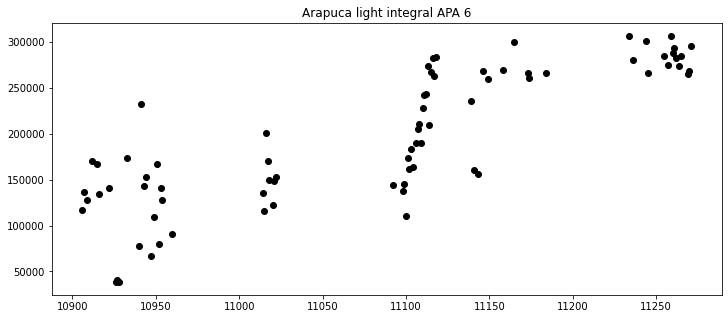

In [23]:
plt.figure(figsize=(12,5))

plt.title('Arapuca light integral APA 6')
plt.errorbar(x=df_integral_603['Run Number'], y=df_integral_603['Integral'], yerr=df_integral_603['stat err'], 
            fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
plt.show()

            

## Plot APA 3 and APA 6 integrals as a function of the time

In [24]:
import matplotlib.patches as patches

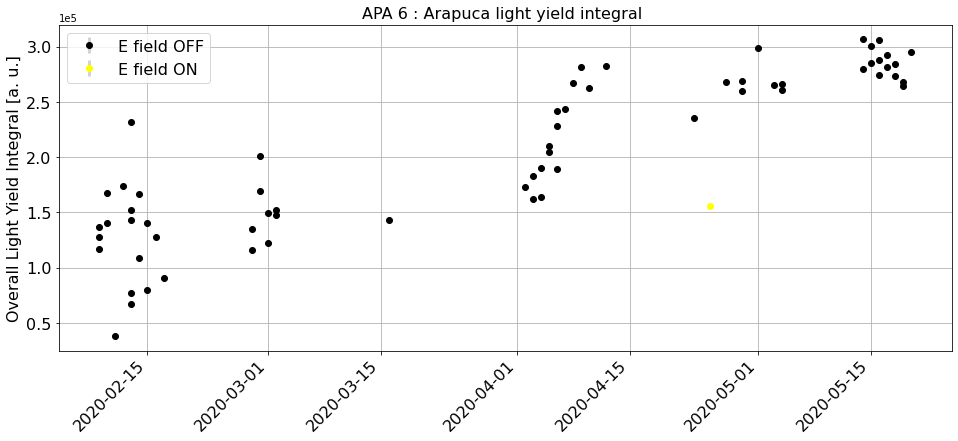

In [25]:
############################################################
#                           APA 6 
############################################################
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

plt.title('APA 6 : Arapuca light yield integral ', fontsize=16)
plt.errorbar(x=df_apa6_efieldOFF['Day/time'], y=df_apa6_efieldOFF['Integral'], yerr=np.sqrt(df_apa6_efieldOFF['stat err']), fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')
plt.errorbar(x=df_apa6_efieldON['Day/time'], y=df_apa6_efieldON['Integral'], yerr=np.sqrt(df_apa6_efieldON['stat err']), fmt='o', color='yellow', ecolor='lightgray', elinewidth=3, capsize=0,  label = 'E field ON')

plt.ylabel('Overall Light Yield Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

#ax.annotate('Preliminary', xytext=('10 April', 0.5), xy=('10 April', 0.5), fontsize = 16 )
plt.legend(fontsize=16)
plt.grid()
plt.show()

fig.savefig('./Integral_A_apa6.pdf')

In [26]:
df_apa3_efieldOFF.head()

,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10877,2020-02-06,2020-02-06 16:06:42+00:00,False,143112.006752,167.263266
1,10878,2020-02-06,2020-02-06 17:20:49+00:00,False,134258.434941,177.208916
2,10879,2020-02-06,2020-02-06 18:27:43+00:00,False,146913.710598,163.000000
3,10885,2020-02-07,2020-02-07 10:59:21+00:00,False,138948.518489,142.635900
4,10903,2020-02-08,2020-02-08 09:40:06+00:00,False,142025.626576,163.187009


In [27]:
mylist = df_apa3_efieldOFF.loc[df_apa3_efieldOFF['Day/time']=='2020-02-06'].index.to_list()
mylist
df_apa3_efieldOFF = df_apa3_efieldOFF.drop(index=mylist).reset_index(drop=True)

df_apa3_efieldOFF.head(30)

,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10885,2020-02-07,2020-02-07 10:59:21+00:00,False,138948.518489,142.635900
1,10903,2020-02-08,2020-02-08 09:40:06+00:00,False,142025.626576,163.187009
2,10904,2020-02-08,2020-02-08 14:55:59+00:00,False,134628.040535,169.575942
3,10905,2020-02-08,2020-02-08 21:55:20+00:00,False,130145.483779,178.165653
4,10906,2020-02-09,2020-02-09 09:38:25+00:00,False,134789.696363,173.458929
5,10907,2020-02-09,2020-02-09 13:08:44+00:00,False,130298.453004,168.083313
6,10909,2020-02-09,2020-02-09 20:41:41+00:00,False,123302.346623,193.514857
7,10915,2020-02-10,2020-02-10 08:53:11+00:00,False,135826.550504,165.254349
8,10922,2020-02-10,2020-02-10 15:40:03+00:00,False,148478.395055,55.127126
9,10928,2020-02-11,2020-02-11 17:37:52+00:00,False,34931.710491,242.812685


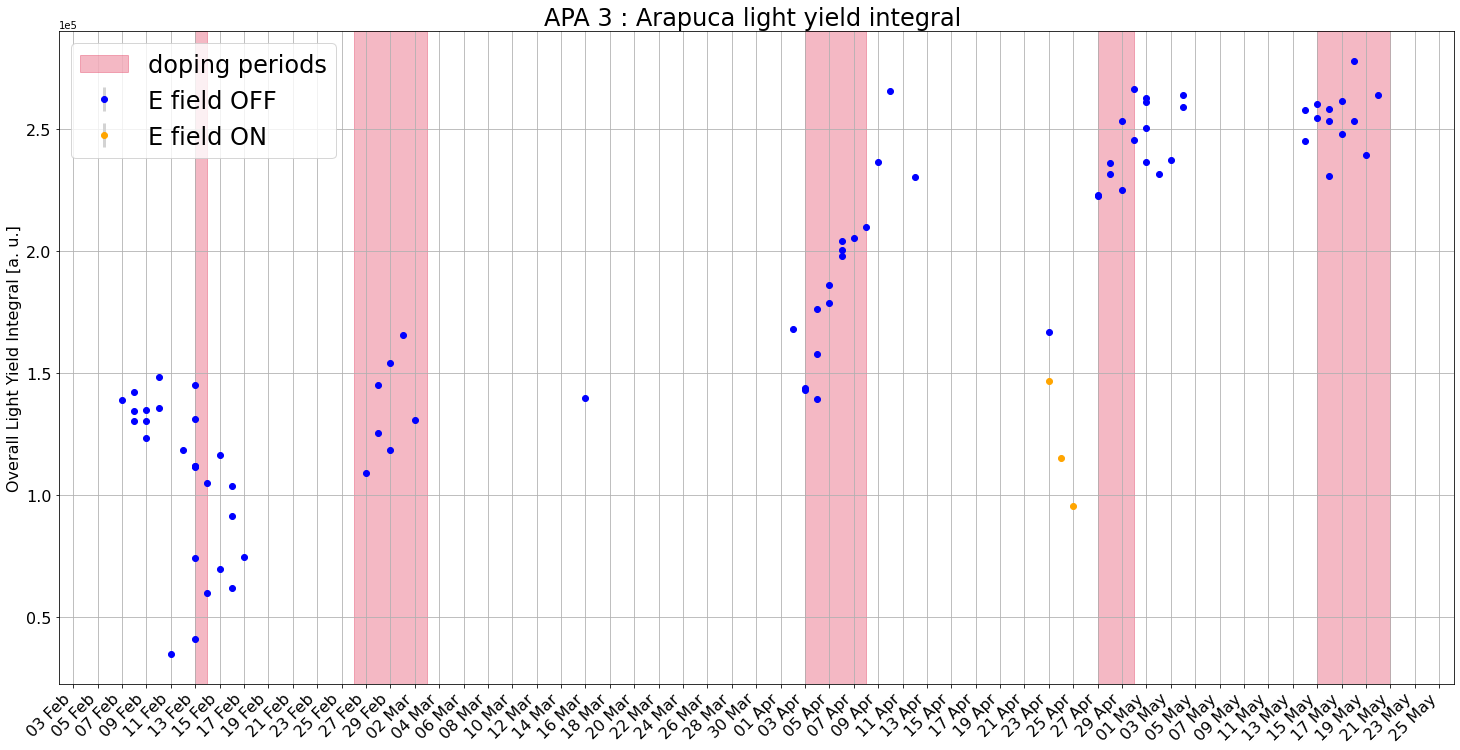

In [376]:
############################################################
#                           APA 3 
############################################################
import matplotlib.dates as mdates
fig = plt.figure(figsize=(25,12))



plt.title('APA 3 : Arapuca light yield integral ', fontsize=24)
plt.errorbar(x=df_apa3_efieldOFF['Day/time'], y=df_apa3_efieldOFF['Integral'], yerr=np.sqrt(df_apa3_efieldOFF['stat err']), fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')

plt.errorbar(x=df_apa3_efieldON['Day/time'], y=df_apa3_efieldON['Integral'], yerr=np.sqrt(df_apa3_efieldON['stat err']), fmt='o', color='orange', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field ON')



plt.ylabel('Overall Light Yield Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

ax = plt.axes()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))   #to get a tick every 15 minutes



plt.axvspan(datestr2num('13 Feb'), datestr2num('14 Feb'),    label="doping periods", color="crimson", alpha=0.3)
plt.axvspan(datestr2num('26 Feb'), datestr2num('3 March'),   color="crimson", alpha=0.3)
plt.axvspan(datestr2num('3 April'), datestr2num('8 April'),  color="crimson", alpha=0.3)
plt.axvspan(datestr2num('27 April'), datestr2num('30 April'),color="crimson", alpha=0.3)
plt.axvspan(datestr2num('15th May'), datestr2num('21 May'),  color="crimson", alpha=0.3)


plt.legend(fontsize=24)

plt.grid()
plt.show()
fig.savefig('./Integral_A_apa3.pdf')


In [161]:
df_ratio_apas = pd.merge(df_apa6_efieldOFF, df_apa3_efieldOFF, how = 'inner', on=['Run Number', 'Day/time'], suffixes=('_APA6', '_APA3'))
df_ratio_apas.head()

,Run Number,Day/time,daytime_APA6,Efield_APA6,Integral_APA6,stat err_APA6,daytime_APA3,Efield_APA3,Integral_APA3,stat err_APA3
0,10906,09 Feb,2020-02-09 09:38:25+00:00,False,117264.588563,80.901174,2020-02-09 09:38:25+00:00,False,134789.696363,173.458929
1,10907,09 Feb,2020-02-09 13:08:44+00:00,False,136793.434553,125.582642,2020-02-09 13:08:44+00:00,False,130298.453004,168.083313
2,10909,09 Feb,2020-02-09 20:41:41+00:00,False,127661.812705,76.111760,2020-02-09 20:41:41+00:00,False,123302.346623,193.514857
3,10915,10 Feb,2020-02-10 08:53:11+00:00,False,167335.857995,54.304696,2020-02-10 08:53:11+00:00,False,135826.550504,165.254349
4,10922,10 Feb,2020-02-10 15:40:03+00:00,False,140715.673310,38.223030,2020-02-10 15:40:03+00:00,False,148478.395055,55.127126


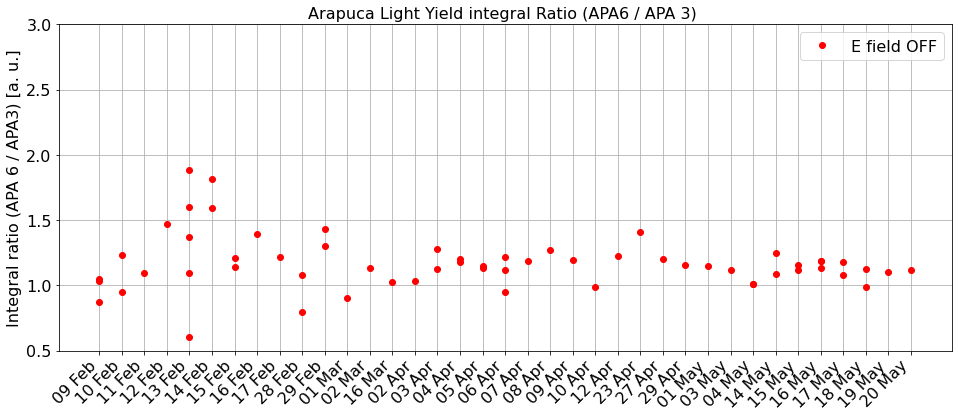

In [221]:
############################################################
#                           RATIO APA 6 / APA 3 
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('Arapuca Light Yield integral Ratio (APA6 / APA 3) ', fontsize=16)
#plt.errorbar(x=df_apa6_efieldOFF['Day/time'], y=df_apa6_efieldOFF['Integral']/df_apa3_efieldOFF['Integral'], fmt='o', color='red', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')

plt.errorbar(x=df_ratio_apas['Day/time'], y=df_ratio_apas['Integral_APA6']/df_ratio_apas['Integral_APA3'], fmt='o', color='red', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')



plt.ylabel('Integral ratio (APA 6 / APA3) [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)
plt.ylim((0.5, 3))

plt.legend(fontsize=16)

plt.grid()
plt.show()
fig.savefig('./ratio_A_apa6vsapa3.pdf')


## Do plots against X-Arapuca

In [229]:
#df_XA = pd.read_csv('./XArapuca_IntegralsSPE.txt', sep= ' ', header=None, index_col=0, names=['W/O quartz', 'W quartz', 'Date', 'Time'])

df_XA = pd.read_csv('./Integral_xarapuca.txt', sep= ' ', header=None, index_col=0, names=['W/O quartz', 'W quartz', 'Date', 'Time'])


df_XA['Date'] = pd.to_datetime(df_XA['Date'], format='%Y:%m:%d')
df_XA['Date'] = df_XA['Date'].dt.strftime('%d %b')

df_XA.tail()

,W/O quartz,W quartz,Date,Time
249,148.480,112.007,19 May,10:57:32
250,161.144,119.672,19 May,14:28:20
251,143.413,108.505,19 May,19:14:47
252,153.433,113.530,19 May,23:05:19
253,167.393,127.876,20 May,09:07:50


In [230]:
# create data frame with both XA infos and APA 3 (APA 6)

df_XA_vs_APA3 = pd.merge(df_XA, df_apa3, how = 'inner', left_on=['Date'], right_on='Day/time')

df_XA_vs_APA6 = pd.merge(df_XA, df_apa6, how = 'inner', left_on=['Date'], right_on='Day/time')


df_XA_vs_APA6.head()


,W/O quartz,W quartz,Date,Time,Run Number,Day/time,daytime,Efield,Integral,stat err
0,39.4964,3.6656,13 Feb,18:40:27,10940,13 Feb,2020-02-13 10:25:28+00:00,False,77186.889488,64.892218
1,39.4964,3.6656,13 Feb,18:40:27,10941,13 Feb,2020-02-13 11:59:56+00:00,False,232205.079817,33.361655
2,39.4964,3.6656,13 Feb,18:40:27,10943,13 Feb,2020-02-13 14:09:54+00:00,False,143452.746462,37.881394
3,39.4964,3.6656,13 Feb,18:40:27,10944,13 Feb,2020-02-13 14:40:36+00:00,False,152623.571707,52.163205
4,39.4964,3.6656,13 Feb,18:40:27,10947,13 Feb,2020-02-13 18:08:48+00:00,False,67262.557810,91.279790


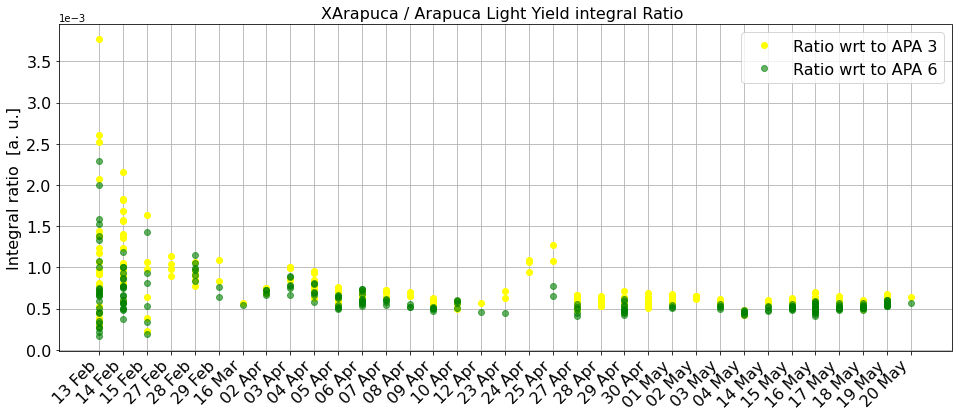

In [264]:
import matplotlib.patches as patches 
from matplotlib.dates import date2num, datestr2num
from datetime import datetime


fig, ax = plt.subplots(figsize=(16, 6))
#fig = plt.figure(figsize=(16,6))
#a0 = plt.subplot(111)

plt.title('XArapuca / Arapuca Light Yield integral Ratio ', fontsize=16)
plt.errorbar(x=df_XA_vs_APA3['Day/time'], y=df_XA_vs_APA3['W/O quartz']/df_XA_vs_APA3['Integral'], fmt='o', color='yellow', ecolor='lightgray', elinewidth=3, capsize=0, label = 'Ratio wrt to APA 3')

plt.errorbar(x=df_XA_vs_APA6['Day/time'], y=df_XA_vs_APA6['W/O quartz']/df_XA_vs_APA6['Integral'], fmt='o', color='green', ecolor='lightgray', elinewidth=3, capsize=0, alpha = 0.6, label = 'Ratio wrt to APA 6')


plt.ylabel('Integral ratio  [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
plt.show()
fig.savefig('./ratio_XA-A.pdf')



In [50]:
df_XA_mean = pd.read_csv('./Integral_xarapuca.txt', sep= ' ', header=None, index_col=0, names=['W/O quartz', 'W quartz', 'Date', 'Time'])


df_XA_mean['Date'] = pd.to_datetime(df_XA_mean['Date'], format='%Y:%m:%d')


df_XA_mean = df_XA_mean.groupby('Date').mean().reset_index()
df_XA_mean.sort_values(by=['Date'], inplace=True)

#
df_apa3_mean = df_apa3.groupby('Day/time').mean().reset_index()
df_apa3_mean.sort_values(by=['Day/time'], inplace=True)

df_apa6_mean = df_apa6.groupby('Day/time').mean().reset_index()
df_apa6_mean.sort_values(by=['Day/time'], inplace=True)


# create data frame with both XA infos and APA 3 (APA 6)
df_XAmean_vs_APA3 = pd.merge(df_XA_mean, df_apa3_mean, how = 'inner', left_on=['Date'], right_on='Day/time')
df_XAmean_vs_APA6 = pd.merge(df_XA_mean, df_apa6_mean, how = 'inner', left_on=['Date'], right_on='Day/time')


df_XAmean_vs_APA3.head()

,Date,W/O quartz,W quartz,Day/time,Run Number,Efield,Integral,n good evts,stat err
0,2020-02-13,90.739100,13.027204,2020-02-13,10944.0,0.0,103845.760172,40625.714286,192.101325
1,2020-02-14,94.937970,25.408371,2020-02-14,10950.0,0.0,82400.756080,105007.500000,322.899579
2,2020-02-15,71.748767,22.927767,2020-02-15,10952.5,0.0,93128.746456,96994.000000,308.732128
3,2020-02-27,110.186400,48.527375,2020-02-27,11013.0,0.0,108863.479248,90707.000000,301.176028
4,2020-02-28,122.720000,66.244000,2020-02-28,11014.5,0.0,135254.342518,102706.000000,320.381574


In [58]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(16,6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

plt.title('XArapuca / Arapuca Light Yield integral Ratio ', fontsize=16)
plt.errorbar(x=df_XAmean_vs_APA3['Day/time'], y=df_XAmean_vs_APA3['W/O quartz']/df_XAmean_vs_APA3['Integral'], fmt='o', color='yellow', ecolor='lightgra', elinewidth=3, capmeansize=0, label = 'Ratio wrt tomean APA 3')

plt.errorbar(x=df_meanXAmean_vs_APA6['Day/time'], y=df_XAmean_vs_APA6['W/O quartz']/df_XAmean_vs_APA6['Integral'], fmt='o', color='green', ecolor='lightgray'#, elinewidth=3, #capsize=0, alpha = 0.6, label = 'Ratio wrt to APA 6')

#ax =# plt.axes()
ax.xaxis.set_major_formatter(mdates.DateFo1matter('%d %b'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))   #to get a tick every 15 minutes


plt.ylabel('Integral ratio  [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)



plt.legend(fontsize=16)

plt.grid()
plt.show()

SyntaxError: invalid syntax (<ipython-input-58-4aac753f6d73>, line 11)

# Draw some calibrated waveform 

In [166]:
#read APA 6 files 

base_path_wfapa6 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod603/wf'
file_path_wfapa6 = os.path.join(base_path_wfapa6,'CalibWaveforms_run*.csv')

file_name_list_wfapa6 =  glob.glob(file_path_wfapa6) 
df_wfapa6 = readfile_list(file_name_list_wfapa6)
df_wfapa6.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_wfapa6.head()

0.528123  0.517570  0.508451  0.503863  0.488292  0.480922  0.477480   

       1720      1721      1722      1723      1724      1725      1726  \
0  0.839428  0.836143  0.836253  0.839634  0.838521  0.834988  0.829339   
1  0.390898  0.386144  0.380805  0.373793  0.363966  0.362904  0.356317   
2  0.655074  0.654778  0.649991  0.645448  0.646597  0.641636  0.639321   
3  0.699560  0.693031  0.686208  0.678283  0.670672  0.663918  0.655767   
4  0.469050  0.460361  0.450180  0.444359  0.436702  0.427784  0.422307   

       1727      1728      1729      1730      1731      1732      1733  \
0  0.828473  0.825944  0.822906  0.818136  0.816940  0.815758  0.805792   
1  0.350234  0.347207  0.340142  0.329199  0.314830  0.312545  0.307366   
2  0.636866  0.630582  0.623984  0.623184  0.618780  0.612339  0.611886   
3  0.654438  0.652637  0.653065  0.652299  0.646332  0.642235  0.640996   
4  0.400312  0.387149  0.378718  0.376281  0.368624  0.361598  0.355347   

       1734      1735      1736      1737      1738      1739      1740  \
0  0.802548  0.800157  0.798961  0.794988  0.788830  0.782782  0.772693   
1  0.290793  0.282639  0.279345  0.268004  0.255441  0.242028  0.230262   
2  0.606316  0.598100  0.593922  0.581058  0.576584  0.568837  0.568072   
3  0.640636  0.638204  0.637416  0.634151  0.628275  0.626158  0.617489   
4  0.348407  0.336277  0.330083  0.315113  0.309894  0.305535  0.303241   

       1741      1742      1743      1744      1745      1746      1747  \
0  0.764253  0.763483  0.762631  0.764267  0.765009  0.761435  0.759566   
1  0.216636  0.206304  0.199319  0.188429  0.178044  0.169704  0.162400   
2  0.564956  0.554267  0.548888  0.541838  0.533831  0.524518  0.517781   
3  0.616003  0.606524  0.603147  0.596549  0.595176  0.595942  0.587363   
4  0.299599  0.290623  0.276170  0.269489  0.255064  0.246146  0.250419   

       1748      1749      1750      1751      1752      1753      1754  \
0  0.755868  0.753765  0.747359  0.746150  0.747387  0.743978  0.743030   
1  0.144552  0.126305  0.110422  0.095096  0.082055  0.075203  0.072786   
2  0.515292  0.503960  0.496683  0.486657  0.485177  0.482531  0.476717   
3  0.583445  0.585111  0.584098  0.582297  0.582387  0.578852  0.570926   
4  0.246777  0.238833  0.235822  0.230632  0.220366  0.214487  0.207260   

       1755      1756      1757      1758      1759      1760      1761  \
0  0.738782  0.741408  0.736047  0.732775  0.732308  0.729504  0.725999   
1  0.065163  0.054725  0.046544  0.041046  0.035389  0.026119  0.013556   
2  0.470990  0.461712  0.455253  0.452207  0.446811  0.440179  0.439012   
3  0.574191  0.572097  0.567706  0.559691  0.557957  0.554422  0.554017   
4  0.199432  0.186929  0.187302  0.189710  0.190255  0.188018  0.176835   

       1762      1763      1764      1765      1766      1767      1768  \
0  0.720665  0.724432  0.719153  0.715786  0.710796  0.707676  0.705449   
1  0.001817 -0.012287 -0.019113 -0.025620 -0.030852 -0.035527 -0.043840   
2  0.432415  0.426531  0.427784  0.419812  0.416504  0.413928  0.409559   
3  0.555503  0.551495  0.537512  0.535171  0.530983  0.529362  0.527583   
4  0.169608  0.166023  0.162295  0.156531  0.149305  0.148473  0.153979   

       1769      1770      1771      1772      1773      1774      1775  \
0  0.708514  0.714892  0.717105  0.713614  0.709765  0.705201  0.701559   
1 -0.049099 -0.056005 -0.063495 -0.056828 -0.064531 -0.073561 -0.082539   
2  0.404580  0.394553  0.393178  0.390672  0.386459  0.385815  0.386755   
3  0.522021  0.521481  0.515289  0.515559  0.509052  0.504774  0.491399   
4  0.149620  0.145577  0.150165  0.155786  0.160804  0.160116  0.169264   

       1776      1777      1778      1779      1780      1781      1782  \
0  0.700033  0.698521  0.695909  0.687978  0.683236  0.682356  0.676597   
1 -0.084982 -0.091968 -0.093614 -0.095181 -0.099590 -0.103070 -0.106841   
2  0.387765  0.384596  0.379409  0.373247  0.369556  0.371767  0.369017   
3  0.487369  0.4877

In [167]:
df_goodwf_apa6 = pd.merge(df_Xerunlist_info, df_wfapa6, how = 'inner', on=['Run Number'])
df_goodwf_apa6.head()

1.310076   

       1719      1720      1721      1722      1723      1724      1725  \
0  0.776319  0.786548  0.801232  0.815219  0.836792  0.845421  0.843612   
1  1.008002  1.015989  1.013855  1.034097  1.035621  1.047266  1.059278   
2  0.655829  0.674209  0.686354  0.692070  0.701552  0.715321  0.724154   
3  0.671549  0.665168  0.661026  0.662481  0.680281  0.681065  0.683528   
4  1.309103  1.313589  1.315805  1.322938  1.338287  1.340989  1.350230   

       1726      1727      1728      1729      1730      1731      1732  \
0  0.849388  0.855024  0.863305  0.869708  0.884252  0.900049  0.913688   
1  1.054766  1.049705  1.047571  1.053181  1.062143  1.069947  1.077691   
2  0.749419  0.752991  0.749679  0.753316  0.754160  0.763318  0.766955   
3  0.676699  0.666735  0.676139  0.677035  0.678490  0.678378  0.682968   
4  1.362390  1.368389  1.376873  1.387250  1.398707  1.407354  1.410920   

       1733      1734      1735      1736      1737      1738      1739  \
0  0.919047  0.932269  0.954050  0.963305  0.985505  1.005129  1.015846   
1  1.073240  1.061594  1.069886  1.063728  1.064094  1.066167  1.055802   
2  0.772411  0.769033  0.772671  0.768384  0.777087  0.782932  0.775788   
3  0.670766  0.651623  0.643562  0.648600  0.642891  0.637069  0.649160   
4  1.410542  1.415406  1.413839  1.407245  1.405678  1.408975  1.409894   

       1740      1741      1742      1743      1744      1745      1746  \
0  1.024614  1.037209  1.057390  1.065811  1.075205  1.075762  1.089262   
1  1.050681  1.058058  1.048669  1.037816  1.031719  1.032999  1.024829   
2  0.769878  0.753965  0.749419  0.757278  0.764227  0.769423  0.771631   
3  0.628785  0.622516  0.618150  0.624755  0.629905  0.644234  0.631584   
4  1.414379  1.421243  1.419837  1.412325  1.415190  1.420540  1.427620   

       1747      1748      1749      1750      1751      1752      1753  \
0  1.100397  1.116611  1.135470  1.142081  1.146326  1.149527  1.142707   
1  1.017147  1.012940  1.002514  0.998673  0.989101  0.977151  0.970810   
2  0.775204  0.780205  0.768059  0.769033  0.767150  0.768709  0.776243   
3  0.638637  0.644346  0.642555  0.657668  0.661138  0.668191  0.676251   
4  1.435510  1.437239  1.438374  1.447778  1.450264  1.450480  1.444913   

       1754      1755      1756      1757      1758      1759      1760  \
0  1.152519  1.158643  1.162262  1.165463  1.182512  1.189402  1.184043   
1  0.962457  0.969408  0.972578  0.976053  0.989040  0.989833  0.982089   
2  0.779750  0.789557  0.786634  0.794233  0.803651  0.804625  0.806119   
3  0.680953  0.687446  0.677594  0.693155  0.692931  0.685766  0.685655   
4  1.450318  1.449237  1.448156  1.446210  1.442427  1.432646  1.419243   

       1761      1762      1763      1764      1765      1766      1767  \
0  1.181329  1.191628  1.198866  1.196987  1.192463  1.190515  1.184809   
1  0.979894  0.983126  0.979102  0.978248  0.969164  0.960628  0.964835   
2  0.800923  0.798780  0.805794  0.814887  0.808847  0.815147  0.820667   
3  0.680729  0.679945  0.690916  0.704014  0.711850  0.694051  0.688901   
4  1.404922  1.394545  1.389033  1.374982  1.362174  1.349636  1.341529   

       1768      1769      1770      1771      1772      1773      1774  \
0  1.177154  1.181468  1.186479  1.186827  1.177780  1.166715  1.158573   
1  0.963250  0.970017  0.974834  0.974102  0.982455  0.997271  1.002697   
2  0.816381  0.820473  0.820343  0.852492  0.870288  0.872366  0.874510   
3  0.685543  0.679050  0.695394  0.688117  0.673228  0.658675  0.652518   
4  1.331045  1.315697  1.293647  1.271436  1.260951  1.256466  1.254304   

       1775      1776      1777      1778      1779      1780      1781  \
0  1.163445  1.160870  1.154398  1.147648  1.144029  1.137488  1.140967   
1  1.012270  1.022756  1.029463  1.038060  1.042999  1.047815  1.047266   
2  0.873730  0.884966  0.893864  0.891461  0.891851  0.884706  0.884706   
3  0.651287  0.651623  0.653973  0.642331  0.643115  0.633599  0.630912   
4  1

In [168]:
df_goodwf_apa6 = df_goodwf_apa6.groupby(['Run Number']).sum().T
df_goodwf_apa6.head()

Run Number,10906,10907,10909,10915,10922,10928,10933,10940,10941,10943,10944,10947,10949,10951,10952,10953,10954,10960,11014,11015,11016,11017,11018,11020,11021,11022,11092,11101,11102,11103,11104,11106,11107,11108,11109,11110,11111,11112,11115,11116,11117,11118,11139,11143,11146,11149,11158,11165,11173,11174,11184,11234,11236,11244,11255,11257,11259,11260,11261,11262,11264,11265,11269,11270,11271
Efield,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ch,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
# Define doping periods 

col = df_goodwf_apa6.columns

apa6_Xedop_pre = [c for c in col if c <10943]
apa6_Xedop_1 = [c for c in col if (c >=10943) & (c <=10960)]
apa6_Xedop_2 = [c for c in col if (c >11008) & (c < 11101)  ]

apa6_Xedop_3 = [c for c in col if (c >11102) & (c < 11143)  ]
apa6_Xedop_4 = [c for c in col if (c >11145) & (c <= 11244)  ]
apa6_Xedop_5 = [c for c in col if (c >=11245) & (c <= 11289)  ]



In [170]:
df_wfapa6_Xe_pre = df_goodwf_apa6[apa6_Xedop_pre]
df_wfapa6_Xe_dop1 = df_goodwf_apa6[apa6_Xedop_1]
df_wfapa6_Xe_dop2 = df_goodwf_apa6[apa6_Xedop_2]
df_wfapa6_Xe_dop3 = df_goodwf_apa6[apa6_Xedop_3]
df_wfapa6_Xe_dop4 = df_goodwf_apa6[apa6_Xedop_4]
df_wfapa6_Xe_dop5 = df_goodwf_apa6[apa6_Xedop_5]

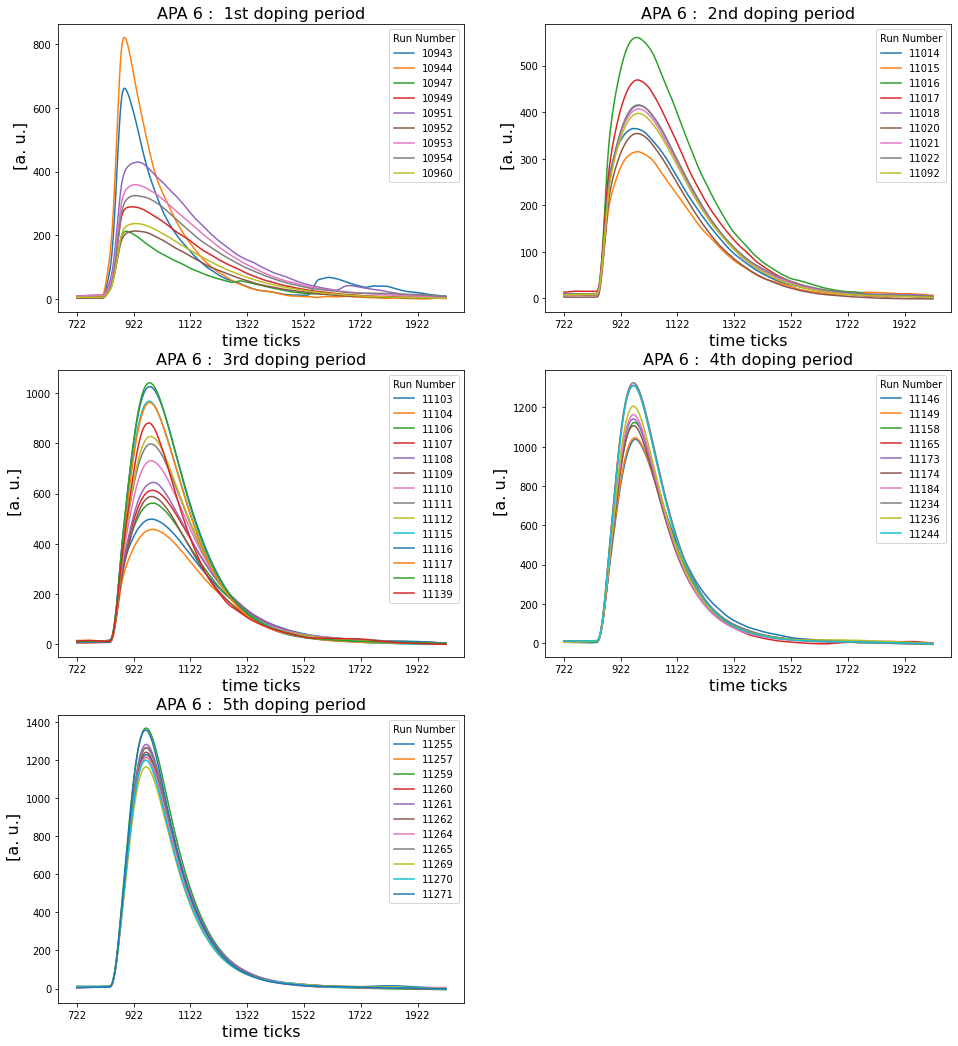

In [171]:
fig = plt.figure(figsize=(16,18))
plt.title('APA 6 : average waveforms', fontsize=16)


ax1=plt.subplot(321)
plt.title('APA 6 :  1st doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa6_Xe_dop1[700:2000].plot(ax=ax1)


ax2=plt.subplot(322)
plt.title('APA 6 :  2nd doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa6_Xe_dop2[700:2000].plot(ax=ax2)



ax3=plt.subplot(323)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
plt.title('APA 6 :  3rd doping period', fontsize=16)
df_wfapa6_Xe_dop3[700:2000].plot(ax=ax3)

ax4=plt.subplot(324)
plt.title('APA 6 :  4th doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa6_Xe_dop4[700:2000].plot(ax=ax4)


ax5=plt.subplot(325)
plt.title('APA 6 :  5th doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa6_Xe_dop5[700:2000].plot(ax=ax5)



plt.show()
fig.savefig('./av_wfs_APA6_perdopingperiod.pdf')


,Run Number,Day/time,Efield,Ch,24,25,26,27,28,29,...,2018,2019,2020,2021,2022,2023,n good evts,pe area_mean,pe area_std,f_cal
0,10906,09 Feb,False,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.631086,0.628372,0.613897,0.592881,0.576458,0.563445,479,428.637319,143.642488,1.000000
1,10906,09 Feb,False,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.661142,0.655411,0.637669,0.624011,0.629194,0.620414,519,451.527191,141.027861,1.053401
2,10906,09 Feb,False,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.732403,0.721491,0.720777,0.723505,0.715841,0.713892,504,436.485996,138.851738,1.018311
3,10906,09 Feb,False,3,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.052078,-0.046592,-0.040659,-0.048272,-0.068870,-0.067974,305,418.461444,151.723009,0.976260
4,10906,09 Feb,False,4,NaN,NaN,NaN,NaN,NaN,NaN,...,0.617246,0.612814,0.601898,0.591305,0.577686,0.566986,557,474.651273,152.808346,1.107349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,11165,01 May,False,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.211106,0.201839,0.199596,0.186143,0.179417,0.159387,223,442.315208,116.415214,1.000000
529,11165,01 May,False,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.270882,0.244884,0.245961,0.226886,0.213195,0.193658,207,463.015333,150.044283,1.046799
530,11165,01 May,False,2,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.339055,-0.350639,-0.372341,-0.384364,-0.380845,-0.387150,229,439.085196,153.428550,0.992697
531,11165,01 May,False,3,NaN,NaN,NaN,NaN,NaN,NaN,...,0.312955,0.317190,0.311461,0.317190,0.280576,0.276591,145,408.246556,135.869679,0.922977


## APA 3 

In [181]:
#read APA 3 files 

base_path_wfapa3 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod304/wf'
file_path_wfapa3 = os.path.join(base_path_wfapa3,'CalibWaveforms_run*.csv')

file_name_list_wfapa3 =  glob.glob(file_path_wfapa3) 
df_wfapa3 = readfile_list(file_name_list_wfapa3)
df_wfapa3.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_wfapa3.head()

0.426587   
3  0.682043  0.681042  0.680521  0.680716  0.678918  0.677111  0.673833   
4  0.653648  0.655541  0.651990  0.650019  0.650870  0.653587  0.655766   

       1721      1722      1723      1724      1725      1726      1727  \
0  0.227951  0.229711  0.227977  0.222684  0.215257  0.212071  0.208831   
1  0.509274  0.510321  0.509202  0.507409  0.508155  0.511921  0.505520   
2  0.428437  0.427017  0.424479  0.420779  0.418735  0.409893  0.400061   
3  0.674099  0.672782  0.672077  0.674906  0.672108  0.672036  0.665348   
4  0.657555  0.659309  0.661401  0.660846  0.661835  0.661314  0.658076   

       1728      1729      1730      1731      1732      1733      1734  \
0  0.210271  0.204657  0.201524  0.202631  0.207817  0.205124  0.205097   
1  0.501440  0.502993  0.497626  0.496266  0.497109  0.500153  0.496531   
2  0.391456  0.381646  0.373794  0.370093  0.362779  0.362284  0.354367   
3  0.664246  0.660876  0.660080  0.658834  0.655965  0.654433  0.651125   
4  0.658371  0.657963  0.658206  0.654863  0.654021  0.653222  0.648412   

       1735      1736      1737      1738      1739      1740      1741  \
0  0.203924  0.204911  0.206417  0.206804  0.207351  0.208244  0.213004   
1  0.495448  0.494510  0.495785  0.497494  0.498504  0.495472  0.490731   
2  0.354475  0.350495  0.350882  0.348559  0.341330  0.338964  0.332854   
3  0.651319  0.653759  0.651789  0.652963  0.649563  0.644968  0.644845   
4  0.646164  0.646928  0.644531  0.641015  0.640980  0.641823  0.639695   

       1742      1743      1744      1745      1746      1747      1748  \
0  0.210004  0.212177  0.216311  0.220391  0.227364  0.235444  0.237564   
1  0.491826  0.493378  0.488806  0.484402  0.481971  0.483692  0.484426   
2  0.329089  0.320312  0.324486  0.323431  0.321796  0.316354  0.312137   
3  0.644212  0.641292  0.642201  0.637432  0.635625  0.634880  0.630877   
4  0.637612  0.638619  0.637924  0.637481  0.642630  0.645530  0.647414   

       1749      1750      1751      1752      1753      1754      1755  \
0  0.240671  0.246844  0.248804  0.250897  0.262911  0.271804  0.279657   
1  0.480515  0.480058  0.482465  0.482549  0.483175  0.480973  0.476364   
2  0.305210  0.297852  0.293270  0.285934  0.280491  0.276898  0.279071   
3  0.629580  0.627793  0.626476  0.623556  0.618328  0.614662  0.615265   
4  0.649107  0.649220  0.649341  0.646094  0.646685  0.650158  0.649967   

       1756      1757      1758      1759      1760      1761      1762  \
0  0.288391  0.295897  0.300697  0.309337  0.314684  0.320231  0.321071   
1  0.473969  0.475786  0.474174  0.473067  0.473428  0.473235  0.466870   
2  0.274704  0.278168  0.278361  0.274489  0.271154  0.268960  0.269541   
3  0.613253  0.615592  0.614438  0.616071  0.616398  0.611916  0.613590   
4  0.653795  0.660029  0.660481  0.660212  0.659838  0.662252  0.661610   

       1763      1764      1765      1766      1767      1768      1769  \
0  0.325884  0.325777  0.329551  0.328764  0.331551  0.332564  0.337244   
1  0.469289  0.468976  0.468916  0.465294  0.465546  0.464644  0.463501   
2  0.266551  0.268035  0.272897  0.271219  0.276210  0.275995  0.280254   
3  0.612498  0.612712  0.608056  0.608618  0.609976  0.607831  0.606330   
4  0.662730  0.668373  0.673383  0.673148  0.675354  0.675206  0.677107   

       1770      1771      1772      1773      1774      1775      1776  \
0  0.342337  0.344417  0.353271  0.357337  0.359137  0.363564  0.362777   
1  0.463609  0.464728  0.461515  0.460517  0.460974  0.463958  0.464030   
2  0.278211  0.282578  0.281287  0.286880  0.286300  0.286708  0.287935   
3  0.607423  0.608076  0.606024  0.608179  0.605013  0.605105  0.605320   
4  0.677003  0.677594  0.676934  0.674442  0.673860  0.671542  0.667592   

       1777      1778      1779      1780      1781      1782      1783  \
0  0.365084  0.367484  0.369817  0.371484  0.373937  0.373364  0.371897   
1  0.467604  0.469421  0.470299  0.469650  0.469228  0.468133  0.465643   
2  0

In [182]:
df_goodwf_apa3 = pd.merge(df_Xerunlist_info, df_wfapa3, how = 'inner', on=['Run Number'])
df_goodwf_apa3.head()

1508  0.834767  0.837044  0.839476  0.835593  0.835894   
2  0.856760  0.851461  0.851561  0.846322  0.843618  0.841143  0.838419   
3  0.705020  0.697891  0.691292  0.682283  0.676198  0.666853  0.663095   
4  0.811420  0.812119  0.814495  0.817456  0.822768  0.820430  0.819795   

       1723      1724      1725      1726      1727      1728      1729  \
0  1.018651  1.010255  1.008568  1.002844  0.997889  0.989678  0.984127   
1  0.836731  0.832490  0.832368  0.837691  0.838740  0.837780  0.832557   
2  0.837580  0.834587  0.829697  0.826534  0.822891  0.823260  0.821255   
3  0.655629  0.650811  0.647006  0.640727  0.635573  0.632105  0.627143   
4  0.817088  0.820023  0.823582  0.823480  0.822235  0.824077  0.826835   

       1730      1731      1732      1733      1734      1735      1736  \
0  0.978328  0.972822  0.968267  0.960293  0.956214  0.956085  0.950697   
1  0.826866  0.824567  0.821074  0.819612  0.820248  0.818619  0.815327   
2  0.820846  0.819858  0.820796  0.816954  0.817413  0.814928  0.817542   
3  0.623530  0.619275  0.614827  0.610074  0.604695  0.602624  0.601355   
4  0.827788  0.825259  0.820544  0.820481  0.816656  0.820176  0.820303   

       1737      1738      1739      1740      1741      1742      1743  \
0  0.943913  0.937811  0.928886  0.922762  0.916444  0.906869  0.903429   
1  0.810584  0.812068  0.810572  0.806934  0.801265  0.801611  0.798788   
2  0.820706  0.824598  0.826025  0.825895  0.826164  0.826583  0.825486   
3  0.598128  0.590693  0.588718  0.580963  0.572244  0.567491  0.571072   
4  0.823150  0.823099  0.823963  0.825666  0.822997  0.821574  0.818968   

       1744      1745      1746      1747      1748      1749      1750  \
0  0.898019  0.895520  0.887016  0.875754  0.864047  0.853683  0.852406   
1  0.797783  0.794804  0.791411  0.784414  0.777930  0.776513  0.773645   
2  0.827741  0.830326  0.832062  0.834158  0.833858  0.837740  0.838868   
3  0.573303  0.569658  0.565885  0.564151  0.555608  0.555962  0.554276   
4  0.819642  0.823658  0.822870  0.822946  0.819795  0.821307  0.815931   

       1751      1752      1753      1754      1755      1756      1757  \
0  0.844032  0.839445  0.831039  0.828496  0.824742  0.818478  0.815524   
1  0.772261  0.769516  0.766101  0.762552  0.759851  0.752274  0.749964   
2  0.840574  0.840265  0.842770  0.843398  0.846202  0.843847  0.841253   
3  0.548029  0.538315  0.531121  0.529965  0.531041  0.531507  0.533096   
4  0.819235  0.819362  0.820074  0.814101  0.811445  0.808675  0.808942   

       1758      1759      1760      1761      1762      1763      1764  \
0  0.807540  0.802985  0.799090  0.790100  0.780882  0.779648  0.775115   
1  0.747497  0.745678  0.744919  0.740734  0.738290  0.736717  0.739094   
2  0.842710  0.842779  0.845733  0.844755  0.845025  0.845843  0.843787   
3  0.530736  0.531972  0.528648  0.529243  0.531892  0.529917  0.528713   
4  0.808408  0.807582  0.808954  0.810365  0.813707  0.810454  0.815245   

       1765      1766      1767      1768      1769      1770      1771  \
0  0.771870  0.769208  0.766254  0.767455  0.766622  0.762338  0.759114   
1  0.737866  0.732387  0.729039  0.723760  0.719118  0.715301  0.708070   
2  0.846402  0.842111  0.835245  0.827681  0.826933  0.826554  0.828949   
3  0.529339  0.526111  0.525180  0.527685  0.525325  0.528006  0.531715   
4  0.812182  0.811992  0.813085  0.814393  0.811941  0.806692  0.807709   

       1772      1773      1774      1775      1776      1777      1778  \
0  0.756041  0.751216  0.747873  0.741089  0.736124  0.735334  0.730119   
1  0.699354  0.697133  0.691375  0.685460  0.682826  0.680538  0.677403   
2  0.828290  0.829178  0.831383  0.828839  0.826134  0.823260  0.821075   
3  0.531780  0.529483  0.532085  0.537143  0.541558  0.540097  0.547403   
4  0.807747  0.809412  0.808065  0.804811  0.804023  0.799296  0.799398   

       1779      1780      1781      1782      1783      1784      1785  \
0  0.730206  0.721128  0.716487  

In [183]:

df_goodwf_apa3 = df_goodwf_apa3.groupby(['Run Number']).sum().T
df_goodwf_apa3.head()

Run Number,10877,10878,10879,10885,10903,10904,10905,10906,10907,10909,10915,10922,10928,10933,10940,10941,10943,10944,10945,10947,10948,10949,10951,10952,10953,10954,10956,10959,10960,11013,11014,11015,11016,11017,11018,11021,11092,11101,11102,11103,11104,11105,11106,11107,11108,11109,11110,11111,11112,11115,11116,11117,11118,11139,11140,11142,11143,11145,11146,11147,11148,11149,11152,11159,11163,11164,11165,11170,11171,11172,11173,11174,11184,11234,11236,11244,11255,11257,11259,11260,11261,11262,11264,11265,11269,11271
Efield,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ch,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
col = df_goodwf_apa3.columns

apa3_Xedop_pre = [c for c in col if c <10943]
apa3_Xedop_1 = [c for c in col if (c >=10943) & (c <=10960)]
apa3_Xedop_2 = [c for c in col if (c >11008) & (c < 11101)  ]

apa3_Xedop_3 = [c for c in col if (c >11102) & (c < 11143)  ]
apa3_Xedop_4 = [c for c in col if (c >11145) & (c <= 11244) ]
apa3_Xedop_5 = [c for c in col if (c >=11245) & (c < 11290)  ]


df_wfapa3_Xe_pre = df_goodwf_apa3[apa3_Xedop_pre]
df_wfapa3_Xe_dop1 = df_goodwf_apa3[apa3_Xedop_1]
df_wfapa3_Xe_dop2 = df_goodwf_apa3[apa3_Xedop_2]
df_wfapa3_Xe_dop3 = df_goodwf_apa3[apa3_Xedop_3]
df_wfapa3_Xe_dop4 = df_goodwf_apa3[apa3_Xedop_4]
df_wfapa3_Xe_dop5 = df_goodwf_apa3[apa3_Xedop_5]

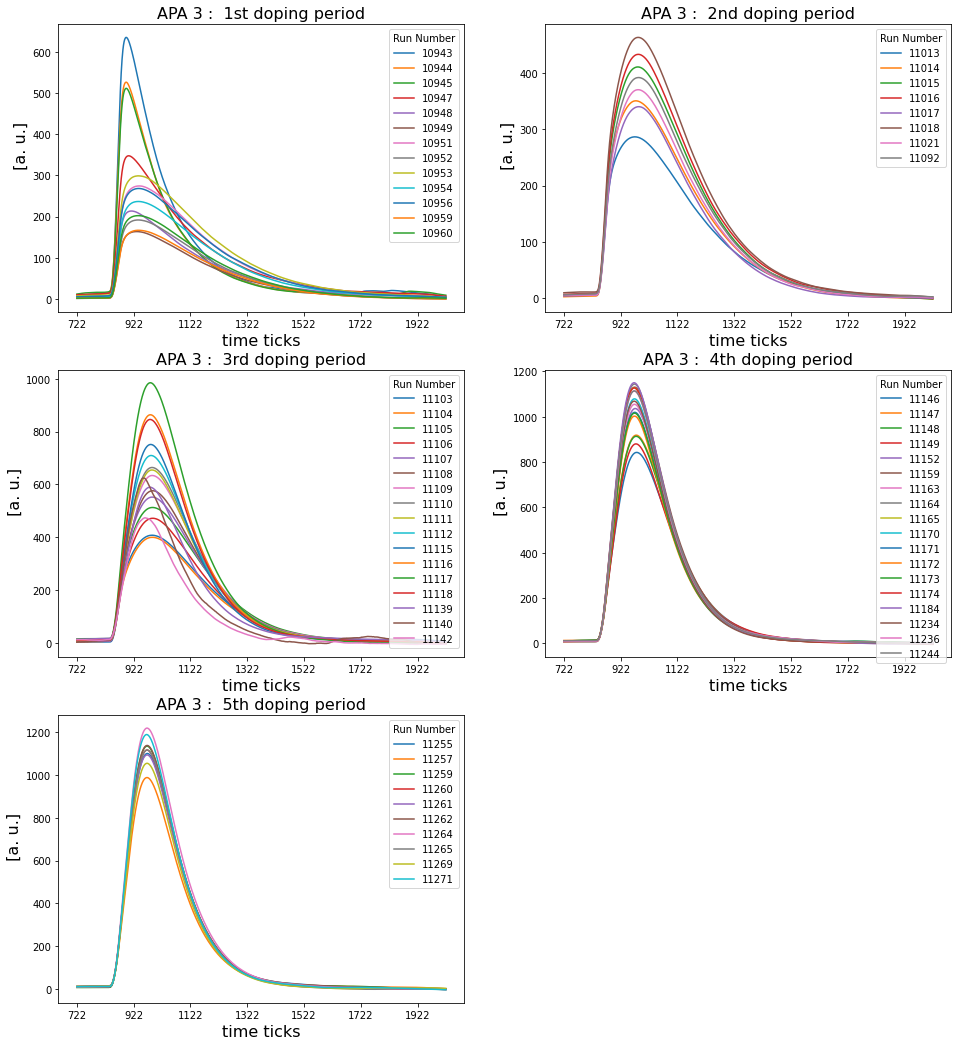

In [185]:
fig = plt.figure(figsize=(16,18))
plt.title('APA 3 : average waveforms', fontsize=16)


ax1=plt.subplot(321)
plt.title('APA 3 :  1st doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16)
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa3_Xe_dop1[700:2000].plot(ax=ax1)

ax2=plt.subplot(322)
plt.title('APA 3 :  2nd doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16)
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa3_Xe_dop2[700:2000].plot(ax=ax2)


ax3=plt.subplot(323)
plt.title('APA 3 :  3rd doping period', fontsize=16)
df_wfapa3_Xe_dop3[700:2000].plot(ax=ax3)
plt.xlabel('time ticks', fontsize=16)
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa3_Xe_dop3[700:2000].plot(ax=ax4)


ax4=plt.subplot(324)
plt.title('APA 3 :  4th doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa3_Xe_dop4[700:2000].plot(ax=ax4)


ax5=plt.subplot(325)
plt.title('APA 3 :  5th doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa3_Xe_dop5[700:2000].plot(ax=ax5)

plt.show()
fig.savefig('./av_wfs_APA3_perdopingperiod.pdf')


In [208]:
#df_bizz = df_wfapa3.loc[(df_wfapa3['Run Number']==11139)]


df_stat_apa3 = df_wfapa3.copy()
df_stat_apa3 = pd.merge(df_Xerunlist_info, df_stat_apa3, how = 'inner', on=['Run Number'])

df_stat_apa3_EfieldON = df_stat_apa3.loc[(df_stat_apa3['Efield'] ==True)]
df_stat_apa3_EfieldOFF = df_stat_apa3.loc[(df_stat_apa3['Efield'] ==False)]

df_stat_apa3_EfieldON = df_stat_apa3_EfieldON.groupby(['Run Number', 'Day/time']).sum()
df_stat_apa3_EfieldON.reset_index(inplace=True)

df_stat_apa3_EfieldOFF = df_stat_apa3_EfieldOFF.groupby(['Run Number', 'Day/time']).sum()
df_stat_apa3_EfieldOFF.reset_index(inplace=True)


df_stat_apa3_EfieldOFF.head()

35916  7.612410  7.579496  7.591850   
4  5.532463  5.495581  5.473634  5.439340  5.417583  5.374071  5.337200   

       1731      1732      1733      1734      1735      1736      1737  \
0  7.457914  7.431723  7.413762  7.395764  7.382258  7.367855  7.349861   
1  6.875061  6.897030  6.900260  6.890635  6.900739  6.918523  6.911014   
2  6.020623  5.986166  5.968517  5.941727  5.900392  5.886440  5.858521   
3  7.559236  7.560902  7.538123  7.522862  7.489930  7.456618  7.454031   
4  5.306857  5.287047  5.261652  5.222074  5.203948  5.179191  5.148292   

       1738      1739      1740      1741      1742      1743      1744  \
0  7.331533  7.320073  7.316826  7.276059  7.248338  7.253744  7.237100   
1  6.928408  6.931016  6.927906  6.926607  6.913719  6.919338  6.918688   
2  5.817898  5.793163  5.777836  5.748610  5.720636  5.712328  5.701420   
3  7.440464  7.447697  7.432591  7.421756  7.413731  7.393322  7.354907   
4  5.122115  5.082226  5.056277  5.037101  5.029652  5.011028  5.020378   

       1745      1746      1747      1748      1749      1750      1751  \
0  7.229720  7.218632  7.183520  7.147691  7.136616  7.117275  7.099791   
1  6.887353  6.882290  6.937336  7.010854  7.067778  7.121237  7.199223   
2  5.666424  5.627752  5.629621  5.620742  5.617608  5.633241  5.632981   
3  7.358337  7.338349  7.340817  7.335699  7.328168  7.355161  7.350811   
4  5.004295  5.005137  4.982689  4.951198  4.910916  4.869869  4.855353   

       1752      1753      1754      1755      1756      1757      1758  \
0  7.081497  7.044957  7.014219  7.021502  6.998251  6.988947  6.978237   
1  7.304969  7.411356  7.547487  7.665936  7.791669  7.962701  8.123276   
2  5.642771  5.634707  5.632057  5.616606  5.618097  5.613396  5.579179   
3  7.347092  7.357303  7.361880  7.363440  7.357603  7.367484  7.365694   
4  4.837633  4.833315  4.823018  4.806286  4.784090  4.780007  4.761466   

       1759      1760      1761      1762      1763      1764      1765  \
0  6.944898  6.919415  6.899960  6.874355  6.852409  6.829132  6.826550   
1  8.283277  8.449368  8.614705  8.788761  8.968831  9.152798  9.323145   
2  5.565065  5.564701  5.550606  5.526347  5.490094  5.467455  5.430402   
3  7.357266  7.321879  7.324292  7.314119  7.308730  7.301547  7.309075   
4  4.771942  4.793379  4.809919  4.803699  4.836873  4.864097  4.903872   

       1766      1767      1768       1769       1770       1771       1772  \
0  6.802720  6.787513  6.762277   6.708678   6.670330   6.647767   6.603265   
1  9.514387  9.700145  9.874581  10.048459  10.256895  10.451215  10.654331   
2  5.389678  5.371602  5.342631   5.335596   5.291540   5.289556   5.257739   
3  7.306109  7.269073  7.261714   7.236582   7.251599   7.263585   7.270645   
4  4.927109  4.979615  5.022461   5.085889   5.125103   5.175972   5.217403   

        1773       1774       1775       1776       1777       1778  \
0   6.575933   6.579438   6.553570   6.524936   6.517437   6.498050   
1  10.843443  11.037893  11.234231  11.421042  11.547633  11.643856   
2   5.231772   5.215232   5.218773   5.213977   5.186759   5.149649   
3   7.256822   7.255151   7.248872   7.246474   7.232262   7.225446   
4   5.282206   5.321103   5.365021   5.403020   5.491293   5.562874   

        1779       1780       1781       1782       1783       1784  \
0   6.470208   6.442150   6.427176   6.403564   6.387921   6.361066   
1  11.768787  11.886752  11.985561  12.041148  12.095863  12.127297   
2   5.116102   5.082886   5.046522   5.009597   4.977812   4.938755   
3   7.221285   7.204018   7.189316   7.193175   7.210850   7.214557   
4   5.647192   5.720741   5.784767   5.849527   5.916671   5.977273   

        1785       1786       1787       1788       1789       1790  \
0   6.308688   6.287467   6.254890   6.232561   6.197415   6.171795   
1  12.162789  12.180806  12.192078  12.189219  12.170874  12.156852   
2   4.919095   4.888633   4.842399   4.819631   4.796901   4.757606   
3   7.226172   7.

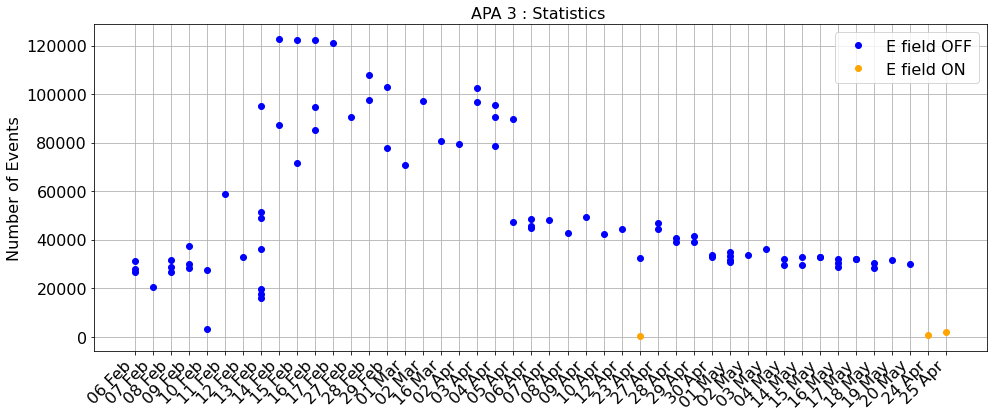

In [210]:
fig = plt.figure(figsize=(16,6))

plt.title('APA 3 : Statistics ', fontsize=16)
plt.errorbar(x=df_stat_apa3_EfieldOFF['Day/time'], y=df_stat_apa3_EfieldOFF['n good evts'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')

plt.errorbar(x=df_stat_apa3_EfieldON['Day/time'], y=df_stat_apa3_EfieldON['n good evts'], fmt='o', color='orange', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field ON')


plt.ylabel('Number of Events', fontsize=16)
#plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
plt.show()

In [186]:
df_apa3_efieldOFF.head()

,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10877,06 Feb,2020-02-06 16:06:42+00:00,False,143112.006752,167.263266
1,10878,06 Feb,2020-02-06 17:20:49+00:00,False,134258.434941,177.208916
2,10879,06 Feb,2020-02-06 18:27:43+00:00,False,146913.710598,163.000000
3,10885,07 Feb,2020-02-07 10:59:21+00:00,False,138948.518489,142.635900
4,10903,08 Feb,2020-02-08 09:40:06+00:00,False,142025.626576,163.187009


In [225]:
apa3_dop1 = (  df_apa3_efieldOFF['Run Number'] >= 10943)  & ( df_apa3_efieldOFF['Run Number']<=11008) 
apa3_dop2 = (  df_apa3_efieldOFF['Run Number'] >= 11009)  & ( df_apa3_efieldOFF['Run Number']<=11101) 
apa3_dop3 = (  df_apa3_efieldOFF['Run Number'] >= 11102)  & ( df_apa3_efieldOFF['Run Number']<=11143) 
apa3_dop4 = (  df_apa3_efieldOFF['Run Number'] >= 11145)  & ( df_apa3_efieldOFF['Run Number']<= 11244)
apa3_dop5 = (  df_apa3_efieldOFF['Run Number'] >= 11245)  



apa6_dop1 = (  df_apa6_efieldOFF['Run Number'] >= 10943)  & ( df_apa6_efieldOFF['Run Number']<=11008) 
apa6_dop2 = (  df_apa6_efieldOFF['Run Number'] >= 11009)  & ( df_apa6_efieldOFF['Run Number']<=11101) 
apa6_dop3 = (  df_apa6_efieldOFF['Run Number'] >= 11102)  & ( df_apa6_efieldOFF['Run Number']<=11143) 
apa6_dop4 = (  df_apa6_efieldOFF['Run Number'] >= 11145)  & ( df_apa6_efieldOFF['Run Number']<= 11244)
apa6_dop5 = (  df_apa6_efieldOFF['Run Number'] >= 11245)  




apa3_afdop1 = (  df_apa3_efieldOFF['Run Number'] >= 10952)  & ( df_apa3_efieldOFF['Run Number']<=11008) 
apa3_afdop2 = (  df_apa3_efieldOFF['Run Number'] >= 11016)  & ( df_apa3_efieldOFF['Run Number']<=11101) 
apa3_afdop3 = (  df_apa3_efieldOFF['Run Number'] >= 11115)  & ( df_apa3_efieldOFF['Run Number']<=11143) 
apa3_afdop4 = (  df_apa3_efieldOFF['Run Number'] >= 11164)  & ( df_apa3_efieldOFF['Run Number']<=11244) 
apa3_afdop5 = (  df_apa3_efieldOFF['Run Number'] >= 11189  ) 


apa6_afdop1 = (  df_apa6_efieldOFF['Run Number'] >= 10952)  & ( df_apa6_efieldOFF['Run Number']<=11008) 
apa6_afdop2 = (  df_apa6_efieldOFF['Run Number'] >= 11016)  & ( df_apa6_efieldOFF['Run Number']<=11101) 
apa6_afdop3 = (  df_apa6_efieldOFF['Run Number'] >= 11115)  & ( df_apa6_efieldOFF['Run Number']<=11143) 
apa6_afdop4 = (  df_apa6_efieldOFF['Run Number'] >= 11164)  & ( df_apa6_efieldOFF['Run Number']<=11244)
apa6_afdop5 = (  df_apa6_efieldOFF['Run Number'] >= 11189 ) 



In [226]:
apa3_int_dop1 = df_apa3_efieldOFF[apa3_dop1]['Integral'].mean()
apa3_int_dop2 = df_apa3_efieldOFF[apa3_dop2]['Integral'].mean()
apa3_int_dop3 = df_apa3_efieldOFF[apa3_dop3]['Integral'].mean()
apa3_int_dop4 = df_apa3_efieldOFF[apa3_dop4]['Integral'].mean()
apa3_int_dop5 = df_apa3_efieldOFF[apa3_dop5]['Integral'].mean()


apa6_int_dop1 = df_apa6_efieldOFF[apa6_dop1]['Integral'].mean()          
apa6_int_dop2 = df_apa6_efieldOFF[apa6_dop2]['Integral'].mean()
apa6_int_dop3 = df_apa6_efieldOFF[apa6_dop3]['Integral'].mean()
apa6_int_dop4 = df_apa6_efieldOFF[apa6_dop4]['Integral'].mean()
apa6_int_dop5 = df_apa6_efieldOFF[apa6_dop5]['Integral'].mean()


apa3_int_afdop1 = df_apa3_efieldOFF[apa3_afdop1]['Integral'].mean()
apa3_int_afdop2 = df_apa3_efieldOFF[apa3_afdop2]['Integral'].mean()
apa3_int_afdop3 = df_apa3_efieldOFF[apa3_afdop3]['Integral'].mean()
apa3_int_afdop4 = df_apa3_efieldOFF[apa3_afdop4]['Integral'].mean()
apa3_int_afdop5 = df_apa3_efieldOFF[apa3_afdop5]['Integral'].mean()


apa6_int_afdop1 = df_apa6_efieldOFF[apa6_afdop1]['Integral'].mean()          
apa6_int_afdop2 = df_apa6_efieldOFF[apa6_afdop2]['Integral'].mean()
apa6_int_afdop3 = df_apa6_efieldOFF[apa6_afdop3]['Integral'].mean()
apa6_int_afdop4 = df_apa6_efieldOFF[apa6_afdop4]['Integral'].mean()
apa6_int_afdop5 = df_apa6_efieldOFF[apa6_afdop5]['Integral'].mean()


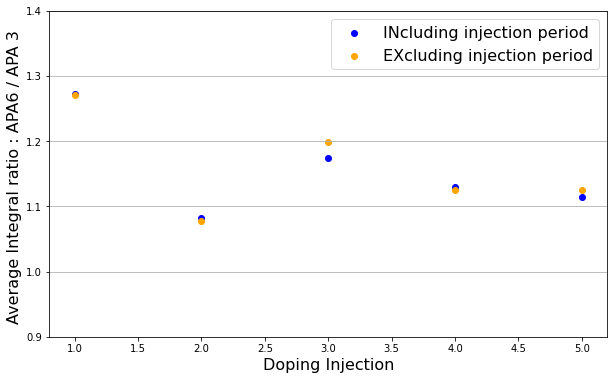

In [227]:
doping = np.arange(1,6)

ratio = np.array([ apa6_int_dop1/apa3_int_dop1 ,
                apa6_int_dop2/apa3_int_dop2,
                apa6_int_dop3/apa3_int_dop3,
                apa6_int_dop4/apa3_int_dop4,
                apa6_int_dop5/apa3_int_dop5]
                 )

ratio_af = np.array([ apa6_int_afdop1/apa3_int_afdop1 ,
                apa6_int_afdop2/apa3_int_afdop2,
                apa6_int_afdop3/apa3_int_afdop3,
                apa6_int_afdop4/apa3_int_afdop4,
                apa6_int_afdop5/apa3_int_afdop5]
                 )


fig = plt.figure(figsize=(10,6))
plt.scatter(x=doping, y=ratio, color='blue', label='INcluding injection period')
plt.scatter(x=doping, y=ratio_af, color='orange', label='EXcluding injection period')


plt.ylim(0.9, 1.4)

plt.ylabel('Average Integral ratio : APA6 / APA 3 ' , fontsize = 16)
plt.xlabel('Doping Injection', fontsize = 16)

plt.grid(axis='y')
plt.legend(fontsize=16)
plt.show()

fig.savefig('./av_ratio_overinjectionperiod.pdf')

In [228]:
ratio

array([1.27245048, 1.08236138, 1.17372449, 1.12969663, 1.11430768])

array([1.23635676, 1.08536868, 1.17017059, 1.12274018, 1.12008337])

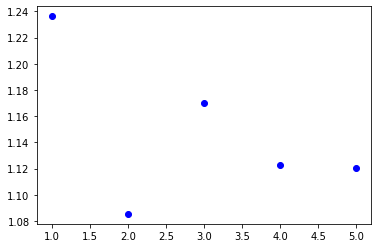

In [218]:
## another way to do the same thing.. 

df_ratio_apas

dop1 = (  df_ratio_apas['Run Number'] >= 10943) & ( df_ratio_apas['Run Number']<=10960) 
dop2 = (  df_ratio_apas['Run Number'] > 11008)  & ( df_ratio_apas['Run Number']<11101) 
dop3 = (  df_ratio_apas['Run Number'] > 11102)  & ( df_ratio_apas['Run Number']<=11143) 
dop4 = (  df_ratio_apas['Run Number'] > 11145)  & ( df_ratio_apas['Run Number']<= 11244)
dop5 = (  df_ratio_apas['Run Number'] >= 11245)  & ( df_ratio_apas['Run Number']< 11290)



apa3_int_dop1 = df_ratio_apas[dop1]['Integral_APA3'].mean()
apa3_int_dop2 = df_ratio_apas[dop2]['Integral_APA3'].mean()
apa3_int_dop3 = df_ratio_apas[dop3]['Integral_APA3'].mean()
apa3_int_dop4 = df_ratio_apas[dop4]['Integral_APA3'].mean()
apa3_int_dop5 = df_ratio_apas[dop5]['Integral_APA3'].mean()


apa6_int_dop1 = df_ratio_apas[dop1]['Integral_APA6'].mean()          
apa6_int_dop2 = df_ratio_apas[dop2]['Integral_APA6'].mean()
apa6_int_dop3 = df_ratio_apas[dop3]['Integral_APA6'].mean()
apa6_int_dop4 = df_ratio_apas[dop4]['Integral_APA6'].mean()
apa6_int_dop5 = df_ratio_apas[dop5]['Integral_APA6'].mean()



doping2 = np.arange(1,6)

#ratio2 = np.array([ apa3_int_dop1/apa6_int_dop1 ,
#                apa3_int_dop2/apa6_int_dop2,
#                apa3_int_dop3/apa6_int_dop3,
#                apa3_int_dop4/apa6_int_dop4,
#                apa3_int_dop5/apa6_int_dop5]
#                 )

ratio2 = np.array([ apa6_int_dop1/apa3_int_dop1 ,
                apa6_int_dop2/apa3_int_dop2,
                apa6_int_dop3/apa3_int_dop3,
                apa6_int_dop4/apa3_int_dop4,
                apa6_int_dop5/apa3_int_dop5]
                 )


plt.scatter(x=doping2, y=ratio2, color='blue')
ratio2

In [217]:
ratio2

array([1.23635676, 1.08536868, 1.17017059, 1.12274018, 1.12008337])

# Check missing runs for both APA3 and APA6 

In [103]:


### check missing runs for both APA 3 and APA 6
df_runlist = df_Xerunlist[['Run Number', 'Day/time','Efield']]
df_runlist.head()

,Run Number,Day/time,Efield
0,10872,06/02/2020,False
1,10873,06/02/2020,False
2,10874,06/02/2020,False
3,10875,06/02/2020,False
4,10877,06/02/2020,False


In [107]:
#APA 3 runs available
df_integral_304.tail()


,Run Number,Integral,stat err
92,11262,261640.533212,178.675684
93,11264,277857.004366,168.389430
94,11265,253069.399996,174.848506
95,11269,239474.199283,178.232994
96,11271,263903.918493,173.663468


In [105]:
#df_apa3_status = df_runlist.join(df_integral_304, on='Run Number', how='left', lsuffix='_list', rsuffix='_apa' )
df_apa3_status = pd.merge(df_runlist, df_integral_304, how='left', on=['Run Number'])
df_apa3_status.head(100)

,Run Number,Day/time,Efield,Integral,stat err
0,10872,06/02/2020,False,NaN,NaN
1,10873,06/02/2020,False,NaN,NaN
2,10874,06/02/2020,False,NaN,NaN
3,10875,06/02/2020,False,NaN,NaN
4,10877,06/02/2020,False,143112.006752,167.263266
...,...,...,...,...,...
95,11172,02/05/2020,False,231681.303300,183.191157
96,11173,03/05/2020,False,237404.137997,189.849941
97,11174,04/05/2020,False,258845.879733,178.916181
98,11184,04/05/2020,False,264029.300455,172.116240


In [106]:
df_apa3_status.loc[(df_apa3_status['Efield']==False) & (df_apa3_status['Integral'].isnull()) ]['Run Number']

0      10872
1      10873
2      10874
3      10875
26     10950
45     11020
47     11022
88     11158
116    11270
118    11272
119    11273
120    11289
Name: Run Number, dtype: int64

In [169]:
df_apa3_status.loc[(df_apa3_status['Run Number']>11018) & (df_apa3_status['Run Number']<= 11022) ]

,Run Number,Day/time,Efield,Integral,stat err
45,11020,01/03/2020,False,NaN,NaN
46,11021,02/03/2020,False,130891.243951,311.462678
47,11022,02/03/2020,False,NaN,NaN


In [108]:
#APA 6 run available

df_integral_603.head()

,Run Number,Integral,stat err
0,10906,117264.588563,80.901174
1,10907,136793.434553,125.582642
2,10909,127661.812705,76.111760
3,10912,169646.176015,52.640289
4,10915,167335.857995,54.304696


In [109]:
df_apa6_status = pd.merge(df_runlist, df_integral_603, how='left', on=['Run Number'])
df_apa6_status.head(100)

,Run Number,Day/time,Efield,Integral,stat err
0,10872,06/02/2020,False,NaN,NaN
1,10873,06/02/2020,False,NaN,NaN
2,10874,06/02/2020,False,NaN,NaN
3,10875,06/02/2020,False,NaN,NaN
4,10877,06/02/2020,False,NaN,NaN
...,...,...,...,...,...
95,11172,02/05/2020,False,NaN,NaN
96,11173,03/05/2020,False,265391.919815,155.074176
97,11174,04/05/2020,False,260941.108352,168.377552
98,11184,04/05/2020,False,266330.055777,163.177817


In [110]:
df_apa6_status.loc[(df_apa6_status['Efield']==False) & (df_apa6_status['Integral'].isnull()) ]['Run Number']

0      10872
1      10873
2      10874
3      10875
4      10877
5      10878
6      10879
7      10885
8      10903
9      10904
10     10905
22     10945
24     10948
26     10950
31     10956
32     10959
39     11013
66     11105
82     11145
84     11147
85     11148
87     11152
89     11159
90     11163
91     11164
93     11170
94     11171
95     11172
118    11272
119    11273
120    11289
Name: Run Number, dtype: int64